<a href="https://colab.research.google.com/github/anasayago/previsionVuelos/blob/main/optimizacion_aeroportuaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevision de Vuelos
Modelo de regresión para predecir los retrasos en vuelos

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import yellowbrick

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de scikit-learn (sklearn): {sklearn.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de yellowbrick: {yellowbrick.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de scikit-learn (sklearn): 1.6.1
Versión de seaborn: 0.13.2
Versión de yellowbrick: 1.5


In [2]:
datos = pd.read_csv('flights.csv')
datos.shape

(71175, 11)

In [3]:
datos.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271


## Conocer los Metadatos

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [5]:
datos.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


In [6]:
datos.describe(include='object')

,airline,aircraft_type,schengen,origin
count,71175,71175,71175,71175
unique,3,6,2,10
top,BZ,Airbus A320,schengen,TZF
freq,47598,30778,42569,14162


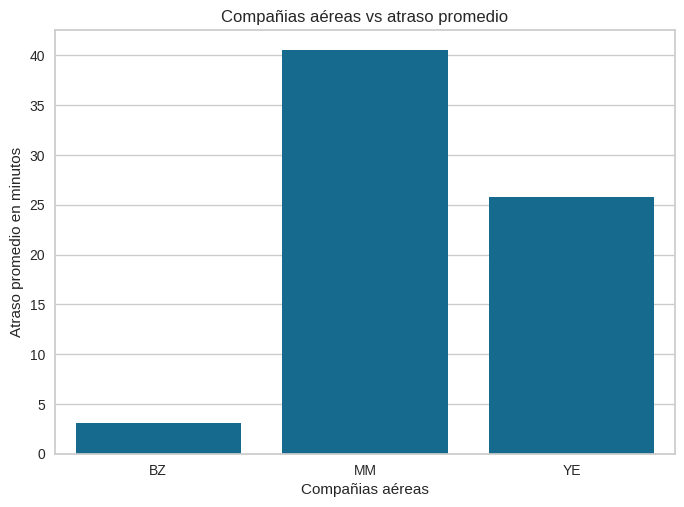

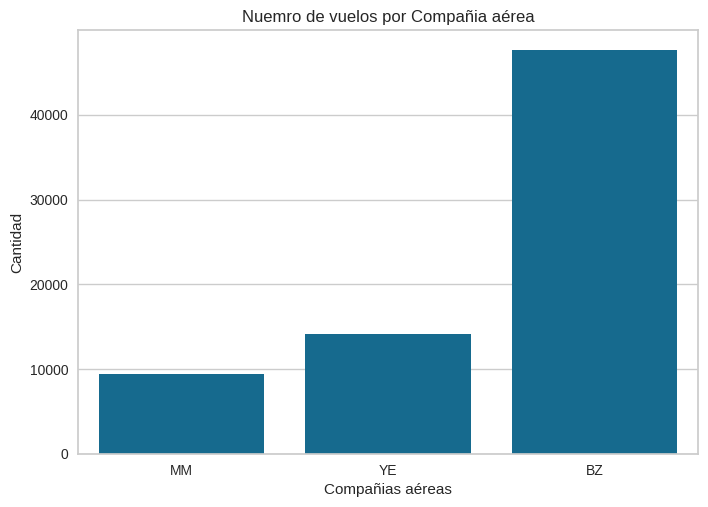

In [7]:
import matplotlib.pyplot as plt
avg_delay = datos.groupby('airline')['delay'].mean().reset_index()
sns.barplot(x='airline',y='delay',data=avg_delay)
plt.title('Compañias aéreas vs atraso promedio')
plt.xlabel('Compañias aéreas')
plt.ylabel('Atraso promedio en minutos')
plt.show()

sns.countplot(data=datos,x='airline')
plt.title('Nuemro de vuelos por Compañia aérea')
plt.xlabel('Compañias aéreas')
plt.ylabel('Cantidad')
plt.show()


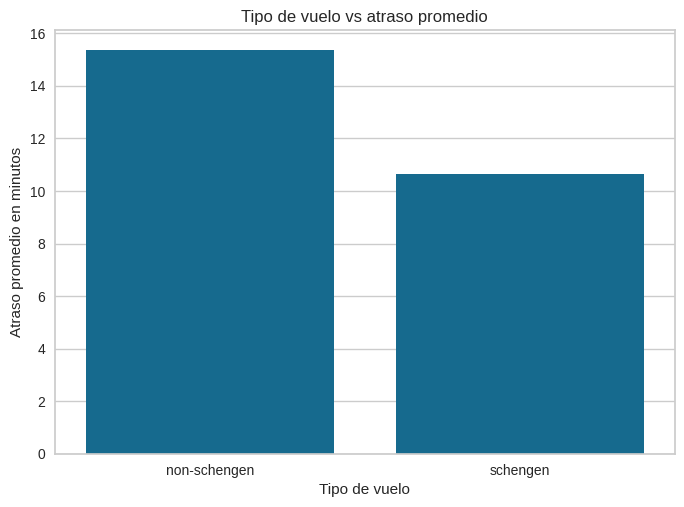

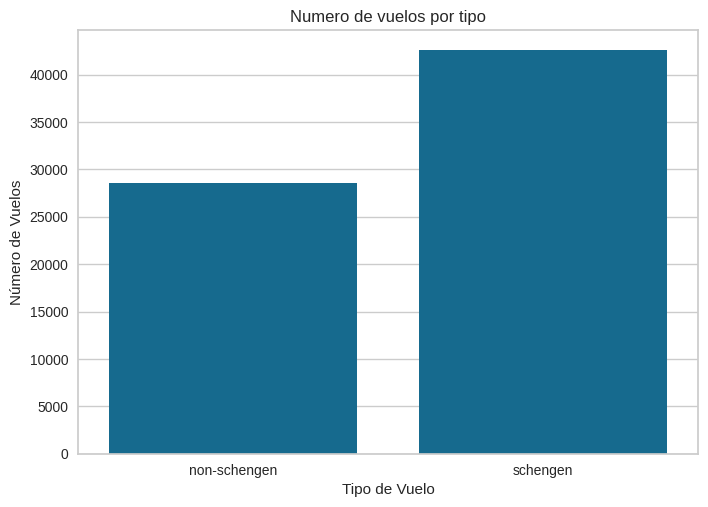

In [8]:
avg_delay = datos.groupby('schengen')['delay'].mean().reset_index()
sns.barplot(x='schengen',y='delay',data=avg_delay)
plt.title('Tipo de vuelo vs atraso promedio')
plt.xlabel('Tipo de vuelo')
plt.ylabel('Atraso promedio en minutos')
plt.show()

sns.countplot(data=datos,x='schengen')
plt.title('Numero de vuelos por tipo')
plt.xlabel('Tipo de Vuelo')
plt.ylabel('Número de Vuelos')
plt.show()

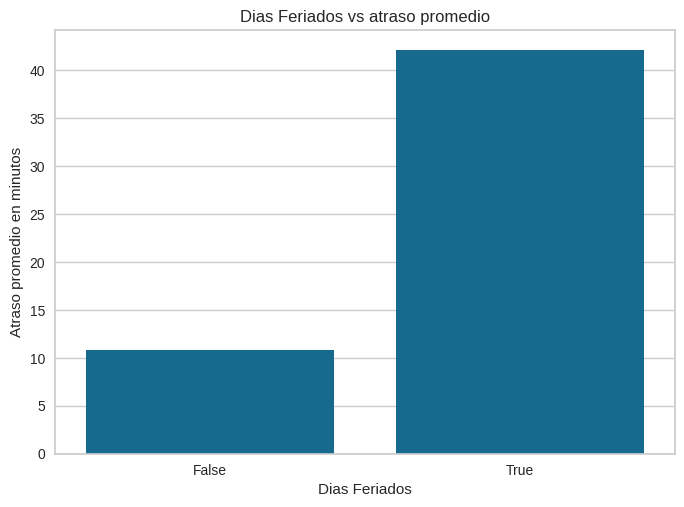

In [9]:
#Ocurre atrasos en dias feriados
avg_delay = datos.groupby('is_holiday')['delay'].mean().reset_index()
sns.barplot(x='is_holiday',y='delay',data=avg_delay)
plt.title('Dias Feriados vs atraso promedio')
plt.xlabel('Dias Feriados')
plt.ylabel('Atraso promedio en minutos')
plt.show()


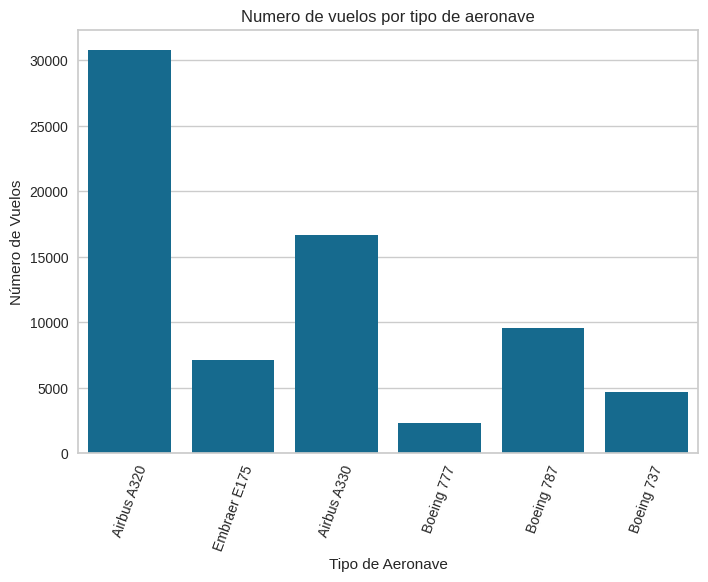

In [10]:
order = datos['aircraft_type'].value_counts().index
sns.countplot(data=datos,x='aircraft_type')
plt.title('Numero de vuelos por tipo de aeronave')
plt.xticks(rotation=70)
plt.xlabel('Tipo de Aeronave')
plt.ylabel('Número de Vuelos')
plt.show()

## Distribución de los Datos
Leer regla de Freedman Diaconis

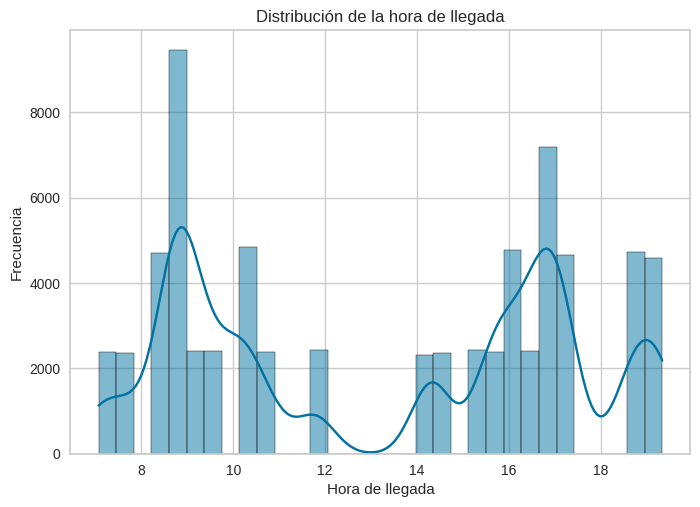

In [11]:
sns.histplot(data=datos,x='arrival_time',kde=True)
plt.title('Distribución de la hora de llegada')
plt.xlabel('Hora de llegada')
plt.ylabel('Frecuencia')
plt.show()

In [12]:
def ancho_bin(df,columna):
  q75,q25 =np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2 * iqr * np.power(len(df[columna]),-1/3)
  return ancho

Ancho de bin: 0.3846176245547029


<Axes: xlabel='arrival_time', ylabel='Count'>

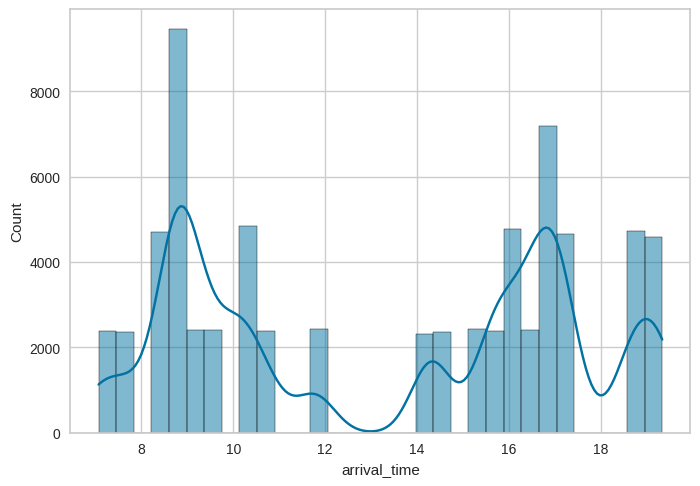

In [13]:
bin_width = ancho_bin(datos,'arrival_time')
print(f'Ancho de bin: {bin_width}')
sns.histplot(data=datos,x='arrival_time',kde=True,binwidth=bin_width)

Ancho de bin: 0.3558030990133985


<Axes: xlabel='departure_time', ylabel='Count'>

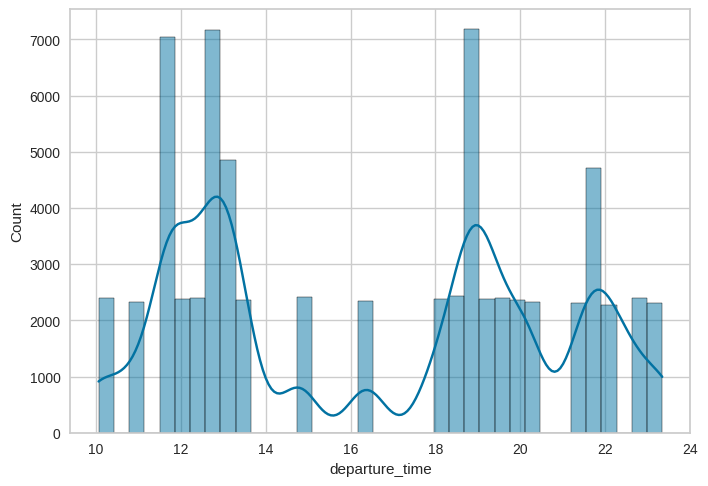

In [14]:
bin_width = ancho_bin(datos,'departure_time')
print(f'Ancho de bin: {bin_width}')
sns.histplot(data=datos,x='departure_time',kde=True,binwidth=bin_width)

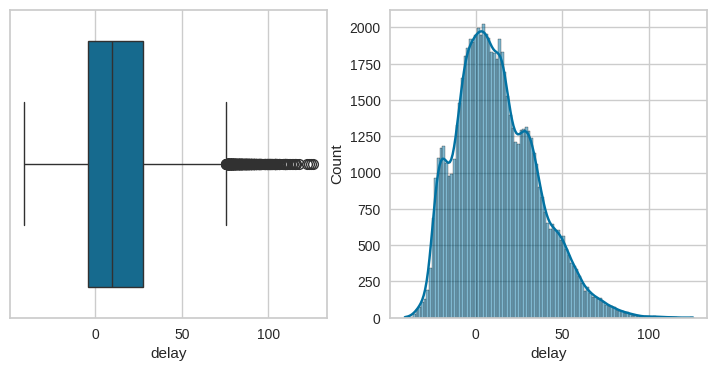

In [15]:
atraso_promedio = datos['delay'].mean()
atraso_mediana = datos['delay'].median()
fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.boxplot(data=datos,x='delay',ax=ax[0])
sns.histplot(data=datos,x='delay',kde=True,ax=ax[1])
plt.show()

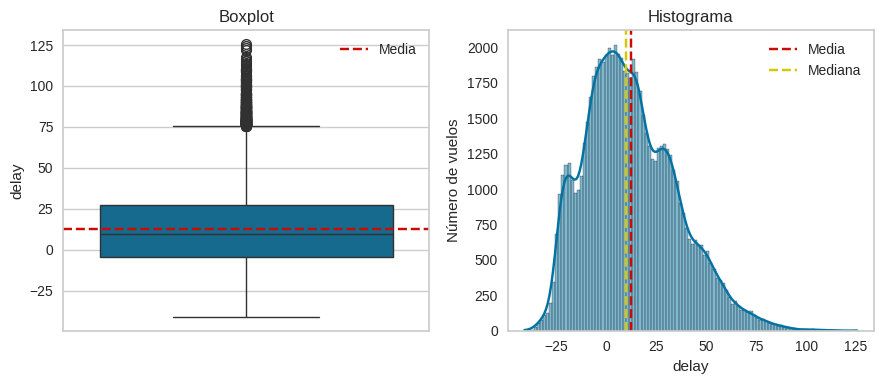

In [16]:
media_retraso = datos['delay'].mean()
mediana_retraso = datos['delay'].median()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(data=datos, y='delay', ax=axes[0])
axes[0].set_title('Boxplot')

axes[0].axhline(y=media_retraso, color='r', linestyle='--', label='Media')
axes[0].legend()

ancho_bin_delay = ancho_bin(datos, 'delay')
sns.histplot(data=datos, x='delay', ax=axes[1], kde=True, binwidth=ancho_bin_delay)
plt.ylabel('Número de vuelos')
plt.grid(False)
axes[1].set_title('Histograma')

axes[1].axvline(x=media_retraso, color='r', linestyle='--', label='Media')
axes[1].axvline(x=mediana_retraso, color='y', linestyle='--', label='Mediana')
axes[1].legend()

plt.tight_layout()
plt.show()

## Clase 2

In [17]:
datos.columns

Index(['flight_id', 'airline', 'aircraft_type', 'schengen', 'origin',
       'arrival_time', 'departure_time', 'day', 'year', 'is_holiday', 'delay'],
      dtype='object')

In [18]:
datos['date'] = datos['year'].astype(str)+'-'+(datos['day']+1).astype(str)
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%j')
datos.tail(2)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date
71173,5,BZ,Airbus A320,schengen,ZQO,9.344097,12.344097,364,2022,True,56.758844,2022-12-31
71174,29,BZ,Boeing 737,schengen,ZQO,8.591208,11.591208,364,2022,True,41.401648,2022-12-31


In [19]:
datos['is_weekend'] = datos['date'].dt.weekday.isin([5,6])
datos['day_name'] = datos['date'].dt.day_name()
datos.sample(5)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,day_name
24204,16,MM,Airbus A320,non-schengen,CSF,17.041281,20.041281,153,2014,False,81.617862,2014-06-03,False,Tuesday
44928,19,MM,Airbus A320,schengen,TZF,16.245220,19.245220,75,2018,False,24.939979,2018-03-17,True,Saturday
42404,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,271,2017,False,-21.576557,2017-09-29,False,Friday
36861,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,267,2016,False,29.302454,2016-09-24,True,Saturday
33765,4,BZ,Airbus A330,schengen,TCY,11.781391,14.781391,61,2016,False,-21.834179,2016-03-02,False,Wednesday


In [20]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   flight_id       71175 non-null  int64         
 1   airline         71175 non-null  object        
 2   aircraft_type   71175 non-null  object        
 3   schengen        71175 non-null  object        
 4   origin          71175 non-null  object        
 5   arrival_time    71175 non-null  float64       
 6   departure_time  71175 non-null  float64       
 7   day             71175 non-null  int64         
 8   year            71175 non-null  int64         
 9   is_holiday      71175 non-null  bool          
 10  delay           71175 non-null  float64       
 11  date            71175 non-null  datetime64[ns]
 12  is_weekend      71175 non-null  bool          
 13  day_name        71175 non-null  object        
dtypes: bool(2), datetime64[ns](1), float64(3), int64(3), o

In [21]:
#quitar los warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
datos['schengen'] = datos['schengen'].replace({'non-schengen':0,'schengen':1})
datos['is_holiday'] = datos['is_holiday'].replace({True:1,False:0})
datos['is_weekend'] = datos['is_weekend'].replace({True:1,False:0})
datos

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,day_name
0,26,MM,Airbus A320,0,TCY,8.885071,10.885071,0,2010,0,70.205981,2010-01-01,0,Friday
1,10,YE,Airbus A320,0,TCY,8.939996,11.939996,0,2010,0,38.484609,2010-01-01,0,Friday
2,3,BZ,Embraer E175,1,TZF,18.635384,22.635384,0,2010,0,2.388305,2010-01-01,0,Friday
3,28,BZ,Airbus A330,0,EMM,15.967963,17.967963,0,2010,0,19.138491,2010-01-01,0,Friday
4,15,BZ,Airbus A330,0,FJB,16.571894,19.571894,0,2010,0,15.016271,2010-01-01,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71170,3,BZ,Embraer E175,1,TZF,18.635384,22.635384,364,2022,1,25.677277,2022-12-31,1,Saturday
71171,17,BZ,Airbus A330,0,CNU,16.718722,21.718722,364,2022,1,52.624348,2022-12-31,1,Saturday
71172,7,MM,Boeing 787,1,TZF,8.564949,13.564949,364,2022,1,56.167080,2022-12-31,1,Saturday
71173,5,BZ,Airbus A320,1,ZQO,9.344097,12.344097,364,2022,1,56.758844,2022-12-31,1,Saturday


In [23]:
categoricas = ['airline','aircraft_type','day_name','origin']
pd.get_dummies(data=datos,columns=categoricas,dtype=int).head()

,flight_id,schengen,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,...,origin_AUZ,origin_CNU,origin_CSF,origin_EMM,origin_FJB,origin_MWL,origin_PUA,origin_TCY,origin_TZF,origin_ZQO
0,26,0,8.885071,10.885071,0,2010,0,70.205981,2010-01-01,0,...,0,0,0,0,0,0,0,1,0,0
1,10,0,8.939996,11.939996,0,2010,0,38.484609,2010-01-01,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1,18.635384,22.635384,0,2010,0,2.388305,2010-01-01,0,...,0,0,0,0,0,0,0,0,1,0
3,28,0,15.967963,17.967963,0,2010,0,19.138491,2010-01-01,0,...,0,0,0,1,0,0,0,0,0,0
4,15,0,16.571894,19.571894,0,2010,0,15.016271,2010-01-01,0,...,0,0,0,0,1,0,0,0,0,0


In [24]:
datos_codificados = pd.get_dummies(data=datos,columns=categoricas,dtype=int)
datos_codificados.sample(5)

,flight_id,schengen,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,...,origin_AUZ,origin_CNU,origin_CSF,origin_EMM,origin_FJB,origin_MWL,origin_PUA,origin_TCY,origin_TZF,origin_ZQO
68331,18,1,14.258911,20.258911,175,2022,0,17.938248,2022-06-25,1,...,0,0,0,0,0,0,0,0,1,0
64680,20,1,16.909690,18.909690,297,2021,0,-0.230538,2021-10-25,0,...,0,0,0,0,0,1,0,0,0,0
7735,19,1,16.245220,19.245220,150,2011,1,46.561614,2011-05-31,0,...,0,0,0,0,0,0,0,0,1,0
37874,30,1,8.923441,12.923441,334,2016,0,-7.186519,2016-11-30,0,...,0,0,0,0,0,0,1,0,0,0
70707,21,1,7.065594,10.065594,333,2022,0,4.241083,2022-11-30,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
datos[['arrival_time','departure_time']].corr()

,arrival_time,departure_time
arrival_time,1.000000,0.973797
departure_time,0.973797,1.000000


tiene una correlación muy fuerte

In [26]:
#remover
df = datos_codificados.drop(columns=['flight_id','year','day','date','departure_time'])
df.head()

,schengen,arrival_time,is_holiday,delay,is_weekend,airline_BZ,airline_MM,airline_YE,aircraft_type_Airbus A320,aircraft_type_Airbus A330,...,origin_AUZ,origin_CNU,origin_CSF,origin_EMM,origin_FJB,origin_MWL,origin_PUA,origin_TCY,origin_TZF,origin_ZQO
0,0,8.885071,0,70.205981,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,8.939996,0,38.484609,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,18.635384,0,2.388305,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,15.967963,0,19.138491,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,16.571894,0,15.016271,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


## Modelado

In [27]:
#crear baseline, puede ser un modelo bobo
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

X = df.drop(columns=['delay']) #delay es nuestra variable de respuesta
y = df['delay']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)

baseline = DummyRegressor()
baseline.fit(X_train,y_train)


DummyRegressor()

In [28]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
y_pred_dummy = baseline.predict(X_test)
def calcular_regresion(y_test,y_pred):
  mse = mean_squared_error(y_test,y_pred,)
  mae = mean_absolute_error(y_test,y_pred)
  r2 = r2_score(y_test,y_pred)
  metrics = {'mse':round(mse**(1/2),4),'mae':round(mae,4), 'r2':round(r2,4)}
  return metrics

In [29]:
resultados = calcular_regresion(y_test,y_pred_dummy)
resultados

{'mse': 22.941, 'mae': 18.4462, 'r2': -0.0003}

In [30]:
from sklearn.ensemble import RandomForestRegressor

modelo = RandomForestRegressor(max_depth=5,random_state=50)
modelo.fit(X_train,y_train)
ypred = modelo.predict(X_test)
resultados_rf = calcular_regresion(y_test,ypred)
resultados_rf

{'mse': 13.7014, 'mae': 11.0399, 'r2': 0.6432}

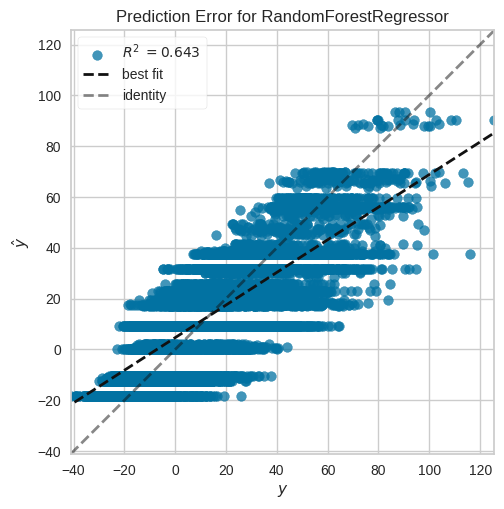

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [31]:
from yellowbrick.regressor import PredictionError
visualizador = PredictionError(modelo)
visualizador.fit(X_train,y_train)
visualizador.score(X_test,y_test)
visualizador.show()

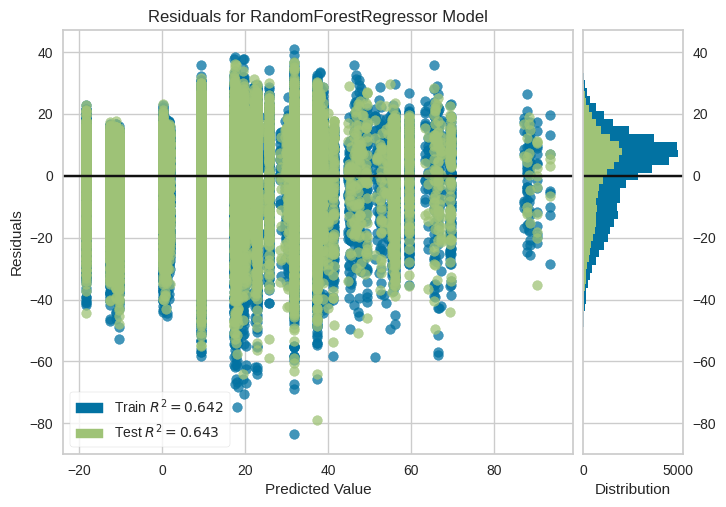

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [32]:
from yellowbrick.regressor import ResidualsPlot
visualizador = ResidualsPlot(modelo)
visualizador.fit(X_train,y_train)
visualizador.score(X_test,y_test)
visualizador.show()

Las idea de los analisis de residuos es que mis datos de prueba tengan un comportamiento a los datos de entrenamiento

In [33]:
cv = sklearn.model_selection.KFold(n_splits=5,shuffle=True,random_state=50)

In [34]:
scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
  'r2': 'r2'
}
cv_results = sklearn.model_selection.cross_validate(modelo,X,y,cv=cv,scoring=scoring)

Se demora porque hace todas las  combinaciones posibles de las metricas

In [35]:
cv_results

{'fit_time': array([4.02016163, 5.6836803 , 3.95758748, 4.24442911, 4.78818798]),
 'score_time': array([0.07239294, 0.0683763 , 0.07973266, 0.09518886, 0.06813145]),
 'test_mse': array([-188.0898086 , -187.70060374, -196.27224008, -192.6791367 ,
        -193.84160621]),
 'test_mae': array([-11.0278275 , -11.05322217, -11.21779281, -11.12149663,
        -11.14870486]),
 'test_r2': array([0.64107706, 0.6516351 , 0.6389191 , 0.64151577, 0.63414445])}

In [36]:
df.columns

Index(['schengen', 'arrival_time', 'is_holiday', 'delay', 'is_weekend',
       'airline_BZ', 'airline_MM', 'airline_YE', 'aircraft_type_Airbus A320',
       'aircraft_type_Airbus A330', 'aircraft_type_Boeing 737',
       'aircraft_type_Boeing 777', 'aircraft_type_Boeing 787',
       'aircraft_type_Embraer E175', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday', 'origin_AUZ', 'origin_CNU',
       'origin_CSF', 'origin_EMM', 'origin_FJB', 'origin_MWL', 'origin_PUA',
       'origin_TCY', 'origin_TZF', 'origin_ZQO'],
      dtype='object')

In [37]:
modelo.feature_importances_

array([9.94520389e-07, 4.19226670e-02, 1.50106775e-01, 3.62944475e-05,
       5.28785443e-01, 3.73353315e-05, 7.45421113e-05, 9.74980471e-02,
       5.93646974e-02, 1.35713499e-04, 2.55186757e-05, 2.15331899e-02,
       4.46756052e-02, 7.36553301e-04, 1.21990863e-04, 4.20792677e-05,
       1.06367311e-04, 1.91862881e-05, 1.43202670e-04, 7.28724759e-05,
       1.61397837e-04, 1.84096848e-04, 1.39550317e-02, 2.75047912e-05,
       5.17014406e-04, 4.39128392e-04, 1.02967652e-02, 2.22064847e-02,
       6.69586981e-03, 7.76306103e-05])

In [38]:
importances = modelo.feature_importances_

In [39]:
feature_importances = pd.DataFrame({'Features':X.columns,
                                    'Importances': (importances*100).round(2)
                                    }).sort_values(by='Importances',ascending=False)
feature_importances

,Features,Importances
4,airline_BZ,52.88
2,is_holiday,15.01
7,aircraft_type_Airbus A320,9.75
8,aircraft_type_Airbus A330,5.94
12,aircraft_type_Embraer E175,4.47
1,arrival_time,4.19
27,origin_TCY,2.22
11,aircraft_type_Boeing 787,2.15
22,origin_CSF,1.40
26,origin_PUA,1.03


In [40]:
resultados =pd.DataFrame(index=['mse','mae','r2'])
model_features = RandomForestRegressor(max_depth=5,random_state=50)
ct_features = [i if i != 0 else 1 for i in range(0,35,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train[selected_features]
  X_test_sel = X_test[selected_features]
  model_features.fit(X_train_sel,y_train)
  y_pred_sel = model_features.predict(X_test_sel)
  metricas = calcular_regresion(y_test,y_pred_sel)
  resultados[i] = metricas.values()

resultados

,1,5,10,15,20,25,30
mse,18.6645,15.1043,13.7147,13.7028,13.7004,13.7010,13.7014
mae,14.8596,12.0673,11.0518,11.0399,11.0381,11.0395,11.0399
r2,0.3379,0.5664,0.6425,0.6431,0.6433,0.6432,0.6432


Atributos mas importantes del modelo

In [41]:
selected_features = feature_importances['Features'].values[:15]
X_selected_features = X[selected_features]
X_selected_features.head()

,airline_BZ,is_holiday,aircraft_type_Airbus A320,aircraft_type_Airbus A330,aircraft_type_Embraer E175,arrival_time,origin_TCY,aircraft_type_Boeing 787,origin_CSF,origin_PUA,origin_TZF,day_name_Friday,origin_FJB,origin_MWL,origin_AUZ
0,0,0,1,0,0,8.885071,1,0,0,0,0,1,0,0,0
1,0,0,1,0,0,8.939996,1,0,0,0,0,1,0,0,0
2,1,0,0,0,1,18.635384,0,0,0,0,1,1,0,0,0
3,1,0,0,1,0,15.967963,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,16.571894,0,0,0,0,0,1,1,0,0


In [42]:
X_train,X_test,y_train,y_test = train_test_split(X_selected_features,y,test_size=0.3,random_state=50)

In [43]:
param_grid = {
    'max_depth':[5,10,15],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,4,6],
    'n_estimators':[100,150,200]
}

In [48]:
from sklearn.model_selection import GridSearchCV
cv = sklearn.model_selection.KFold(n_splits=5,shuffle=True,random_state=50)
model_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=cv,scoring='r2')
model_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=50, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='r2')

In [49]:
model_grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 100}

In [50]:
y_pred_grid = model_grid.predict(X_test)
resultados_grid = calcular_regresion(y_test,y_pred_grid)
resultados_grid

{'mse': 13.192, 'mae': 10.6549, 'r2': 0.6692}

In [52]:
resultados['modelo_grid'] = list(resultados_grid.values())
resultados

,1,5,10,15,20,25,30,modelo_grid
mse,18.6645,15.1043,13.7147,13.7028,13.7004,13.7010,13.7014,13.1920
mae,14.8596,12.0673,11.0518,11.0399,11.0381,11.0395,11.0399,10.6549
r2,0.3379,0.5664,0.6425,0.6431,0.6433,0.6432,0.6432,0.6692


In [53]:
import pickle

try:
  with open('champion.pkl','wb') as file:
    pickle.dump(model_grid.best_estimator_,file)
  print('Modelo serializado con éxito')
except Exception as e:
  print('Se presentó un error al almacenar el modelo: ',str(e))

Modelo serializado con éxito
